<h1><center>Spark Context and basic MapReduce operations</center></h1>

## We have a 100x100 board.
### We throw 3 stones a Million times.
<img src="misc/board.png" width="200">
## Week 3: Reading files with SparkContext and Intro to Lambda Expressions
### Given the XY position of each stone in the board <br> can we calculate how many of them forms a valid triangle?

In [3]:
from pyspark import SparkContext

In [4]:
sc = SparkContext.getOrCreate()

### we take string lines

In [43]:
triangles = sc.textFile("data/triangles.csv")
# triangles = sc.parallelize(triangles.take(10000))   # if you wish to take a smaller sample
triangles.take(5)

['13 27, 68 55, 12 62',
 '64 96, 91 62, 43 51',
 '28 44, 93 59, 68 4',
 '60 8, 87 65, 93 98',
 '4 65, 2 77, 18 85']

<h1><center>Lambda Expressions</center> <img src="misc/lambda.jpg" width="400" align="middle"/></h1>

In [44]:
distance = lambda p1, p2: ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5
def sure_distance(p1, p2):
    x1, y1 = p1 # (13, 27)
    x2, y2 = p2 # (68, 55)
    dist = ((x2 - x1)**2 + (y2- y1)**2)**0.5
    return dist

In [45]:
distance((4,0), (0,3))
sure_distance((4,0), (0,3))

5.0

In [46]:
l = [(1,'z'), (2,'a')]

In [47]:
sorted(l)

[(1, 'z'), (2, 'a')]

In [48]:
sorted(l, key=lambda x: x[1])

[(2, 'a'), (1, 'z')]

### Let's deal with each line alone

In [49]:
sample_line = triangles.take(1)[0]
sample_line

'13 27, 68 55, 12 62'

### 1) split the string line by comma ,

In [50]:
split_comma = lambda line: line.split(',')
splitted_sample = split_comma(sample_line)
splitted_sample

['13 27', ' 68 55', ' 12 62']

### 2.1) Convert a string point to a tuple of integer x-y position
#### PS. Tuples are your friends

In [51]:
point_str2tuple = lambda point_str: tuple([int(ps) for ps in point_str.split()]) # this is just a substep
point_str2tuple(splitted_sample[0])

(13, 27)

### 2.2) Take every string point in the list and convert it to x-y integer position

In [52]:
splitted2points = lambda splitted_line: tuple([point_str2tuple(i) for i in splitted_line])
sample_points = splitted2points(splitted_sample)
sample_points

((13, 27), (68, 55), (12, 62))

### 3) Validate a triangle

In [53]:
def isvalid_triangle(p1, p2, p3):
    l1 = distance(p1, p2)
    l2 = distance(p2, p3)
    l3 = distance(p3, p1)
    return l1+l2>l3 and l1+l3>l2 and l2+l3 > l1

In [54]:
points_valid_triangle = lambda points: isvalid_triangle(*points)
points_valid_triangle(sample_points)

True

### 4) Combine all previous steps in one function

In [55]:
line2valid = lambda line: points_valid_triangle(
    splitted2points(
        split_comma(line)))
line2valid(sample_line)

True

## Week 4: Map, Reduce and Filtering operations

<h1><center>Map/Reduce</center></h1>
<img src="misc/mapreduce.jpeg" width="1000">

In [56]:
validated_triangles = triangles.map(line2valid)
validated_triangles.take(5)

[True, True, True, True, True]

In [57]:
num_triangles = validated_triangles.reduce(lambda x,y: x+y)
num_triangles

999

![title](misc/oneline.jpg)

In [58]:
num_triangles_short = triangles.map(lambda line:line.split(','))\
                                .map(lambda splitted_line: tuple([
                                    tuple([int(ps) for ps in point_str.split()])
                                        for point_str in splitted_line]))\
                                .map(lambda points: isvalid_triangle(*points))\
                                .reduce(lambda x, y: x+y)
num_triangles_short

999

## Filter: Choose only valid triangles

In [59]:
valid_triangles = triangles.map(lambda line:line.split(','))\
                                .map(lambda splitted_line: tuple([
                                    tuple([int(ps) for ps in point_str.split()])
                                        for point_str in splitted_line]))\
                                .filter(lambda points: isvalid_triangle(*points))
valid_triangles.count()

999

## RDD as a Python dictionary?

In [60]:
triangles_id = valid_triangles.map(lambda x: (hash(tuple(x)), tuple(x)))
triangles_id.take(5)

[(-973281609, ((13, 27), (68, 55), (12, 62))),
 (-1943038625, ((64, 96), (91, 62), (43, 51))),
 (935403028, ((28, 44), (93, 59), (68, 4))),
 (555573573, ((60, 8), (87, 65), (93, 98))),
 (1402881299, ((4, 65), (2, 77), (18, 85)))]

In [61]:
triangles_zip = valid_triangles.zipWithUniqueId()\
                                .map(lambda x: (x[1], x[0]))
triangles_zip.take(5)

[(0, ((13, 27), (68, 55), (12, 62))),
 (4, ((64, 96), (91, 62), (43, 51))),
 (8, ((28, 44), (93, 59), (68, 4))),
 (12, ((60, 8), (87, 65), (93, 98))),
 (16, ((4, 65), (2, 77), (18, 85)))]

### Let's record the circumference of each valid triangle

In [62]:
def get_circumference(p1, p2, p3):  # if it is an attribute triangle.circumference, otherwise call it get_circumference(*triangle)
    l1 = distance(p1, p2)
    l2 = distance(p2, p3)
    l3 = distance(p1, p3)
    return l1 + l2 +l3

In [63]:
circumferences = valid_triangles.map(lambda points: (points, get_circumference(*points)))
circumferences.take(5)

[(((13, 27), (68, 55), (12, 62)), 153.16718353495094),
 (((64, 96), (91, 62), (43, 51)), 142.3197117729059),
 (((28, 44), (93, 59), (68, 4)), 183.69209268352833),
 (((60, 8), (87, 65), (93, 98)), 192.4716796394055),
 (((4, 65), (2, 77), (18, 85)), 54.46718011206216)]

## Sort triangles with their circumferences, top first

In [64]:
sorted_triangles_circum = circumferences.sortBy(lambda triangle_circum: triangle_circum[1], ascending=False)
sorted_triangles_circum.take(5)

[(((1, 9), (17, 100), (90, 14)), 294.3413678734133),
 (((0, 54), (6, 1), (95, 98)), 289.67679380447237),
 (((96, 6), (92, 97), (7, 59)), 287.7810477570703),
 (((94, 95), (12, 13), (71, 1)), 272.9464151078346),
 (((3, 11), (91, 80), (77, 1)), 266.7292928636583)]

<img src="misc/hash.png" width="200" align="left">
<h1>"Hashing is your friend"</h1>
<h2><center>Efficiency</center></h2>

In [65]:
hash_circumference = valid_triangles.map(lambda points: (hash(points), get_circumference(*points)))
hash_circumference.take(5)

[(-973281609, 153.16718353495094),
 (-1943038625, 142.3197117729059),
 (935403028, 183.69209268352833),
 (555573573, 192.4716796394055),
 (1402881299, 54.46718011206216)]

In [66]:
id_circumference = triangles_zip.map(lambda index_points: (index_points[0], get_circumference(*index_points[1])))
id_circumference.take(5)

[(0, 153.16718353495094),
 (4, 142.3197117729059),
 (8, 183.69209268352833),
 (12, 192.4716796394055),
 (16, 54.46718011206216)]

## Week 5: Flattening & Joining
### Find number of neighbours of each triangle. Triangles that share at least one vertex (point) are neighbours.
### 1) Let's flatten the points of each triangle

In [67]:
flattened_point2id = triangles_zip.flatMap(lambda index_points: [(tuple(point), index_points[0]) for point in index_points[1]])
flattened_point2id.take(6)

[((13, 27), 0),
 ((68, 55), 0),
 ((12, 62), 0),
 ((64, 96), 4),
 ((91, 62), 4),
 ((43, 51), 4)]

### 2) Let's group by Key (point): in python that would be {point: [list of triangles sharing this point]}

In [68]:
point2ids = flattened_point2id.groupByKey()\
                        .mapValues(lambda triangles: set(triangles))
point2ids.first()

((12, 62), {0})

## Now we have point > triangle_id   and point > [list of triangle ids]
## We need triangle_id > [list of neighbouring triangle ids]
## 3) Join: Let's join point2ids and point2id by their common key (point)

In [78]:
point_id_neighbours = flattened_point2id.join(point2ids)
point_id_neighbours.first()

((39, 11), (24, {24}))

<img src="misc/neighbours_.PNG" align="middle" width="200">

### 4.1) Let's remove the point key, or column (stay tuned) 
### 4.2) Then let's group the RDD by key; Triangle ID
### 4.3) When we group them then we need to take:
### the length of <br> the set of <br> the union of <br> all neighbours' ids
### Q. Each Triangle ID should have how many lists of neighbours' IDs?
#### A. Generally 3, one for each vertex (point) in the triangle

In [79]:
                                                # x: (point, (triangle_id, neighbours_ids))
id_neighbours = point_id_neighbours.map(lambda x: x[1])\
                                    .groupByKey()\
                                    .mapValues(lambda sets: len(set.union(*sets))-1)\
                                    .cache()
            # This -1 is to not count the triangle as a neighbour for itself
id_neighbours.take(5)  # Triangle Id: number of neighbours

[(24, 1), (32, 0), (56, 2), (64, 1), (776, 1)]

## Let's join neighbours and circumferences!

In [80]:
                                        # (id, (neighbour, circumference))
neighbours_circumference = id_neighbours.join(id_circumference).map(lambda x: x[1])
neighbours_circumference.take(5)

[(1, 110.08304046060968),
 (0, 179.54209441384404),
 (2, 97.36338575368117),
 (2, 154.07888595400993),
 (0, 197.03565179454932)]

In [82]:
x_num_neighbours = neighbours_circumference.map(lambda x:x[0]).take(1000)
y_circumference = neighbours_circumference.map(lambda x:x[1]).take(1000)

## Let's Scatter Plot it!
### All you need to do is >  %matplotlib inline

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt

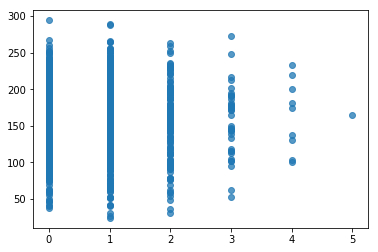

In [84]:
plt.scatter(x_num_neighbours, y_circumference, alpha=0.75)